#**Table Of Content**
- [Introduction](#Introduction)
- [Import Packages & Read dataset](#Import-Packages--Read-dataset)
- [Data Information & Preprocessing](#Data-Information--Preprocessing)
- [Data Decomposition](#Data-Decomposition)
- [ADF Test](#Adf-Test)
- [ACF & PACF Ploting](#acf--pacf-ploting)
- [SARIMA model](#sarima-model)
- [SARIMAX model](#sarimax-model)
- [LSTM model](#lstm-model)
- [Models Evaluation](#models-evaluation)
- [Clustring model](#clustring-model)



## **Introduction**

The dataset used in this project is the ”Walmart Weekly Sales dataset”, which provides historical sales records for 45 Walmart stores located in different regions across the United States. Each store contains multiple departments, and the dataset captures weekly sales for each department over a span of nearly three years.

### Dataset Feature Descriptions

- `Store`: Store number (e.g., 1, 2, ...). Identifies the location.
- `Dept`: Department number (e.g., 1, 2, ...). Represents product categories.
- `Date`: Weekly date of the record (time index for forecasting).
- `Weekly_Sales`: Actual weekly sales revenue for the specific store and department.
- `IsHoliday`: Boolean value indicating if the week includes a major holiday (True/False).

#### features.csv:
- `Temperature`: Average temperature that week (in Fahrenheit).
- `Fuel_Price`: Average fuel price per gallon in the region.
- `MarkDown1–MarkDown5`: Promotional markdowns in different product areas.
- `CPI`: Consumer Price Index, reflects inflation (regional).
- `Unemployment`: Unemployment rate (regional).
- `Type`: Store type (A, B, or C) indicating size and location.
- `Size`: Square footage of the store.

#### Dataset link : https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

## **Import Packages & Read dataset**

In [1]:
pip install tslearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score

In [3]:
train = pd.read_csv('/content/train.csv')
features = pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')

<ipython-input-3-597e12ebc940>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train.csv')


## **Data Information & Preprocessing**

In [4]:
# show train.csv
print("=== Train Data ===")
print(train.head())

# show features.csv
print("\n=== Features Data ===")
print(features.head())

# show stores.csv
print("\n=== Stores Data ===")
print(stores.head())


=== Train Data ===
   Store  Dept        Date  Weekly_Sales IsHoliday
0      1     1  2010-02-05      24924.50     False
1      1     1  2010-02-12      46039.49      True
2      1     1  2010-02-19      41595.55     False
3      1     1  2010-02-26      19403.54     False
4      1     1  2010-03-05      21827.90     False

=== Features Data ===
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2  

In [5]:
# Merge train and features data on Store and Date
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
# Merge the result with stores data on Store
df = pd.merge(df, stores, on='Store', how='left')

# Show the first 5 rows of the final merged dataset
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241338 entries, 0 to 241337
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         241338 non-null  int64  
 1   Dept          241338 non-null  int64  
 2   Date          241338 non-null  object 
 3   Weekly_Sales  241338 non-null  float64
 4   IsHoliday_x   241338 non-null  object 
 5   Temperature   241338 non-null  float64
 6   Fuel_Price    241338 non-null  float64
 7   MarkDown1     86518 non-null   float64
 8   MarkDown2     68905 non-null   float64
 9   MarkDown3     80452 non-null   float64
 10  MarkDown4     85848 non-null   float64
 11  MarkDown5     86518 non-null   float64
 12  CPI           241338 non-null  float64
 13  Unemployment  241338 non-null  float64
 14  IsHoliday_y   241338 non-null  bool   
 15  Type          241338 non-null  object 
 16  Size          241338 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(3)
mem

In [7]:
print(train['Weekly_Sales'].describe())

count    241338.000000
mean      17602.840792
std       24483.998174
min       -1699.000000
25%        2817.917500
50%        8612.850000
75%       22120.662500
max      693099.360000
Name: Weekly_Sales, dtype: float64


In [8]:
df = df[df['Weekly_Sales'] >= 0].copy()

In [9]:
print(df['Weekly_Sales'].describe())

count    240628.000000
mean      17654.993477
std       24501.231574
min           0.000000
25%        2853.622500
50%        8656.740000
75%       22182.217500
max      693099.360000
Name: Weekly_Sales, dtype: float64


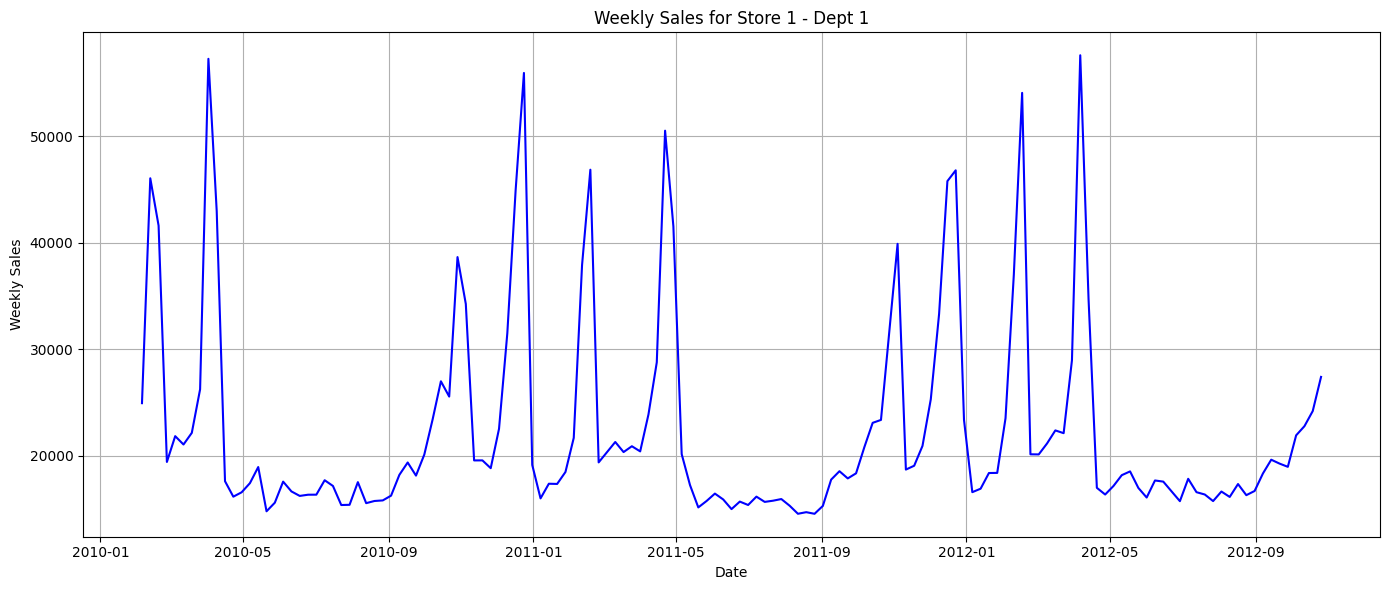

In [10]:
# Filter the data for Store 1 and Dept 1
df_subset = df[(df['Store'] == 1) & (df['Dept'] == 1)].copy()

# Convert 'Date' column to datetime
df_subset['Date'] = pd.to_datetime(df_subset['Date'])

# Sort the data by date to ensure correct time order
df_subset.sort_values('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(df_subset['Date'], df_subset['Weekly_Sales'], color='blue')
plt.title('Weekly Sales for Store 1 - Dept 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Check for null values
null_counts = df_subset.isnull().sum()
print("Null values per column")
print(null_counts)

Null values per column
Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday_x       0
Temperature       0
Fuel_Price        0
MarkDown1        92
MarkDown2       101
MarkDown3        93
MarkDown4        92
MarkDown5        92
CPI               0
Unemployment      0
IsHoliday_y       0
Type              0
Size              0
dtype: int64


In [12]:
# Check for duplicated rows
duplicate_count = df_subset.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicate_count}")


Number of duplicated rows: 0


## **Data Decomposition**

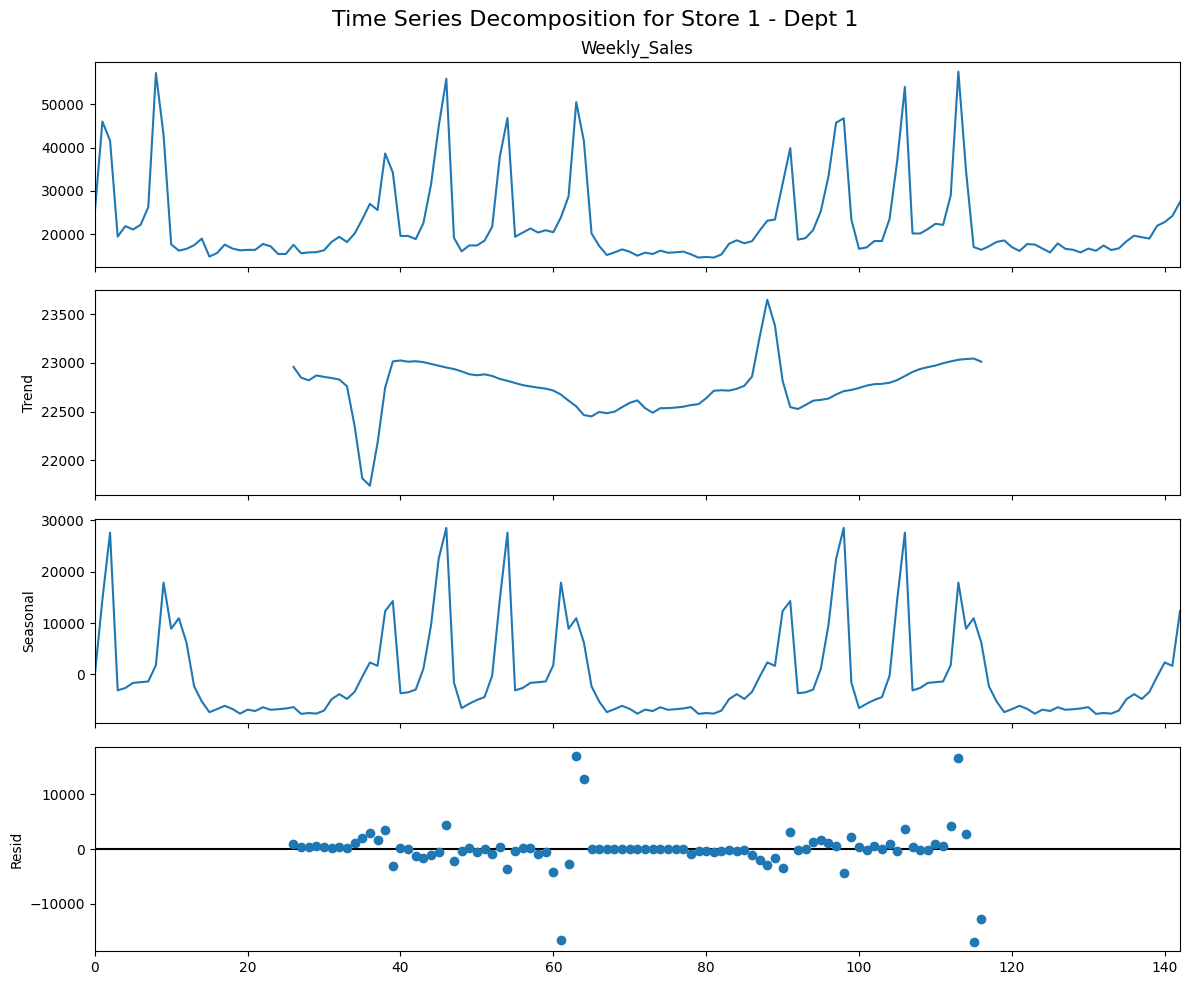

In [13]:
# Apply decomposition with weekly frequency
decomposition = seasonal_decompose(df_subset['Weekly_Sales'], model='additive', period=52)

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (12, 10)})
decomposition.plot()
plt.suptitle('Time Series Decomposition for Store 1 - Dept 1', fontsize=16)
plt.tight_layout()
plt.show()

## **ADF Test**

In [14]:
# Apply ADF test on Weekly Sales
result = adfuller(df_subset['Weekly_Sales'])

# Show the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.5221638686500367
p-value: 0.11017432282586997


In [15]:
#first-order differencing
weekly_sales_diff = np.diff(df_subset['Weekly_Sales'], n=1)

# Check the shape
print("Original series length:", len(df_subset['Weekly_Sales']))
print("Differenced series length:", len(weekly_sales_diff))

Original series length: 143
Differenced series length: 142


In [16]:
# ADF test on the differenced series
result_diff = adfuller(weekly_sales_diff)

print('ADF Statistic (after differencing):', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic (after differencing): -11.044311466768818
p-value: 5.269934445888141e-20


In [17]:
seasonal_diff = np.diff(df_subset['Weekly_Sales'], n=52)  # seasonal differencing

result_seasonal_diff = adfuller(seasonal_diff)
print("ADF Statistic:", result_seasonal_diff[0])
print("p-value:", result_seasonal_diff[1])

ADF Statistic: -22.535053916373815
p-value: 0.0


## **ACF & PACF Ploting**

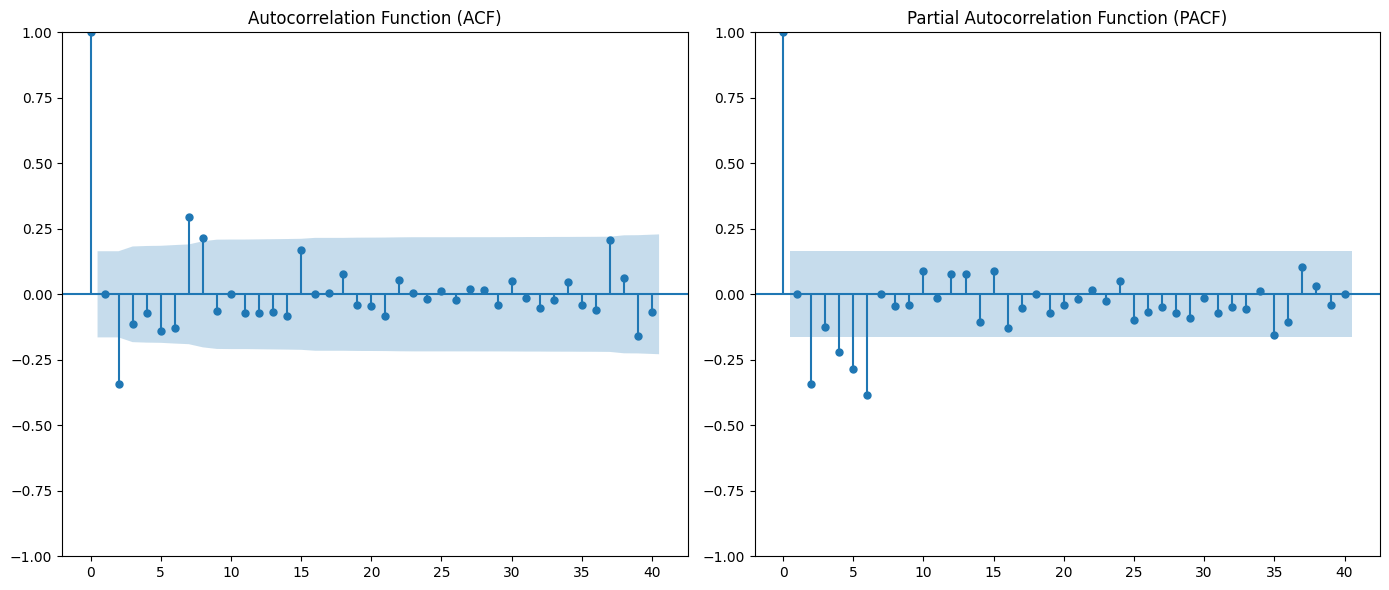

In [18]:
plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(weekly_sales_diff, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot PAC
plt.subplot(1, 2, 2)
plot_pacf(weekly_sales_diff, lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


## **Resuidal Analysis**

In [19]:
# Define ranges for p, q, P, Q
ps = range(0, 4, 1)   # p: AR terms
qs = range(0, 4, 1)   # q: MA terms
Ps = range(0, 4, 1)   # P: seasonal AR
Qs = range(0, 4, 1)   # Q: seasonal MA

# Show the ranges
print("p values:", list(ps))
print("q values:", list(qs))
print("P values:", list(Ps))
print("Q values:", list(Qs))

p values: [0, 1, 2, 3]
q values: [0, 1, 2, 3]
P values: [0, 1, 2, 3]
Q values: [0, 1, 2, 3]


In [20]:
# all combinations of (p, q, P, Q)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
print("Sample combinations:", SARIMA_order_list[:10])

Sample combinations: [(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1)]


In [21]:
warnings.filterwarnings("ignore")

# Fixed parameters from previous steps
d = 1     # regular differencing
D = 1     # seasonal differencing
s = 52    # seasonal period (weekly → yearly cycle)

# List to store the results
results = []

# Loop through all parameter combinations (section-style)
for p_q_P_Q in SARIMA_order_list:
    print("In for loop")

    # Unpack the combination into individual values
    p = p_q_P_Q[0]
    q = p_q_P_Q[1]
    P = p_q_P_Q[2]
    Q = p_q_P_Q[3]

    print(f"Trying: (p,d,q)=({p},{d},{q}) & (P,D,Q,s)=({P},{D},{Q},{s})")

    try:
        # Create and fit the SARIMA model
        model = SARIMAX(
            df_subset['Weekly_Sales'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        fitted_model = model.fit(disp=False)

        # Calculate AIC and save the result
        aic = fitted_model.aic
        results.append({
            'order': (p, d, q),
            'seasonal_order': (P, D, Q, s),
            'aic': aic
        })

        print(f"AIC: {aic:.2f}")

    except Exception as e:
        # Skip any combination that causes an error
        print(f"Skipped combination due to error: {e}")


In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(0,1,0,52)
AIC: 1883.91
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(0,1,1,52)
AIC: 778.67
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(0,1,2,52)
AIC: 6.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(0,1,3,52)
AIC: 8.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(1,1,0,52)
AIC: 799.48
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(1,1,1,52)
AIC: 779.87
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(1,1,2,52)
AIC: 8.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(1,1,3,52)
AIC: 10.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(2,1,0,52)
AIC: 6.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(2,1,1,52)
AIC: 8.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(2,1,2,52)
AIC: 10.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(2,1,3,52)
AIC: 12.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(3,1,0,52)
AIC: 8.00
In for loop
Trying: (p,d,q)=(0,1,0) & (P,D,Q,s)=(3,1,1,52)
AIC: 10.00
In for loop
Trying: (

In [22]:
# Convert results list of dicts to DataFrame
result_df = pd.DataFrame(results)

# Sort by AIC ascending
result_df_sorted = result_df.sort_values(by='aic', ascending=True)

# Show top 5 models
result_df_sorted.head(10)

,order,seasonal_order,aic
2,"(0, 1, 0)","(0, 1, 2, 52)",6.0
8,"(0, 1, 0)","(2, 1, 0, 52)",6.0
6,"(0, 1, 0)","(1, 1, 2, 52)",8.0
3,"(0, 1, 0)","(0, 1, 3, 52)",8.0
9,"(0, 1, 0)","(2, 1, 1, 52)",8.0
12,"(0, 1, 0)","(3, 1, 0, 52)",8.0
24,"(0, 1, 1)","(2, 1, 0, 52)",8.0
18,"(0, 1, 1)","(0, 1, 2, 52)",8.0
72,"(1, 1, 0)","(2, 1, 0, 52)",8.0
66,"(1, 1, 0)","(0, 1, 2, 52)",8.0


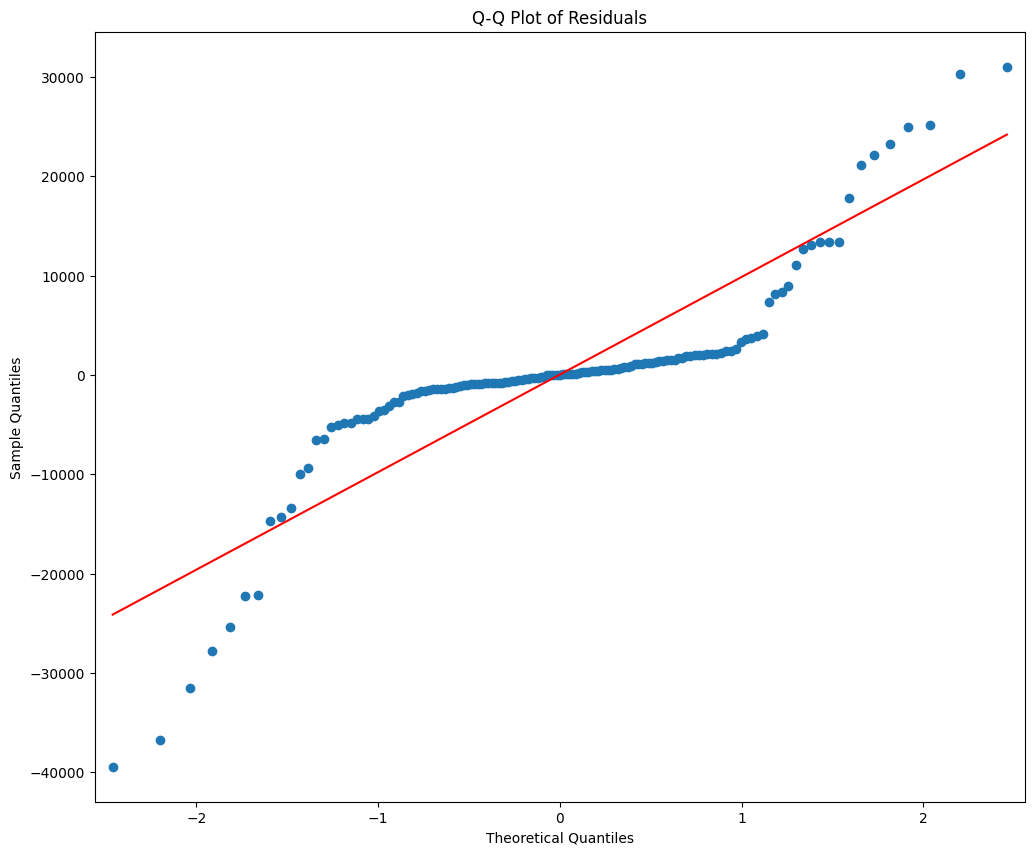

Ljung-Box test result:
     lb_stat  lb_pvalue
10  43.69763   0.000004


In [23]:
# Fit the best SARIMA model
model = SARIMAX(
    df_subset['Weekly_Sales'],
    order=(0, 1, 0),
    seasonal_order=(0, 1, 2, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
fitted_model = model.fit()

# Get residuals
residuals = fitted_model.resid

# Q-Q plot
sm.qqplot(residuals.dropna(), line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box test result:")
print(ljung_box_result)

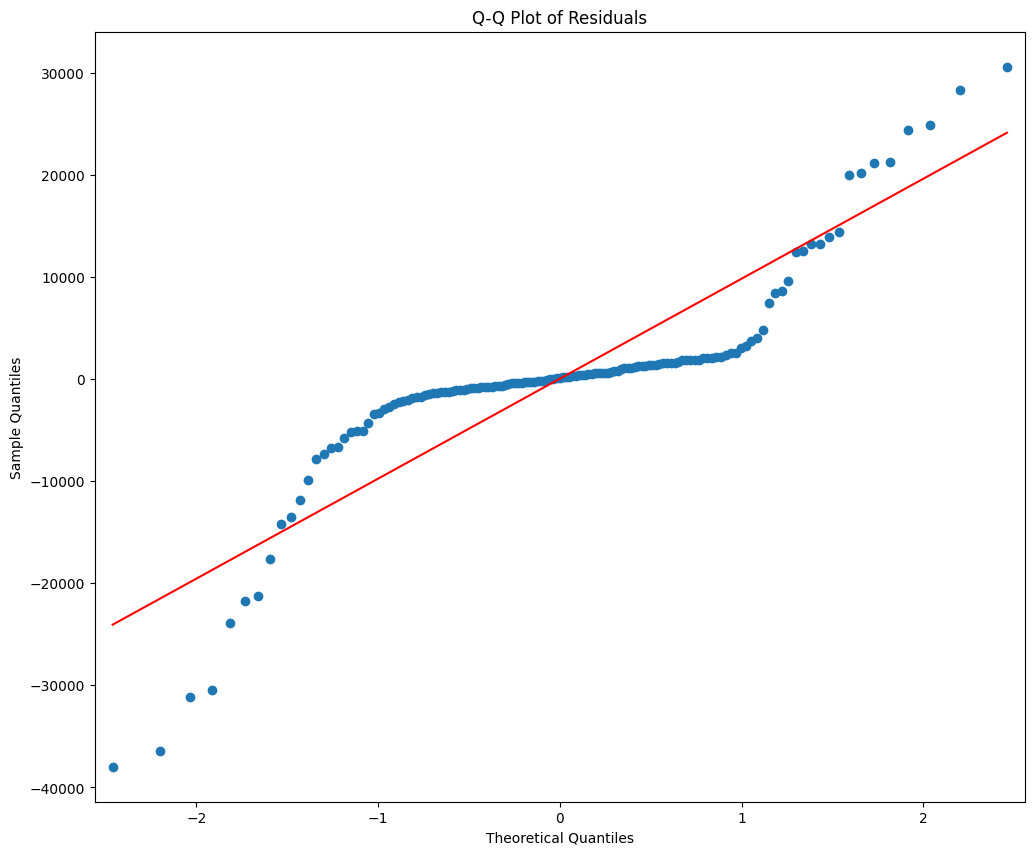

Ljung-Box test result:
      lb_stat  lb_pvalue
10  38.163063   0.000036


In [24]:
# Fit the best SARIMA model
model = SARIMAX(
    df_subset['Weekly_Sales'],
    order=(1, 1, 0),
    seasonal_order=(2, 1, 0, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
fitted_model = model.fit()

# Get residuals
residuals = fitted_model.resid

# Q-Q plot
sm.qqplot(residuals.dropna(), line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box test result:")
print(ljung_box_result)

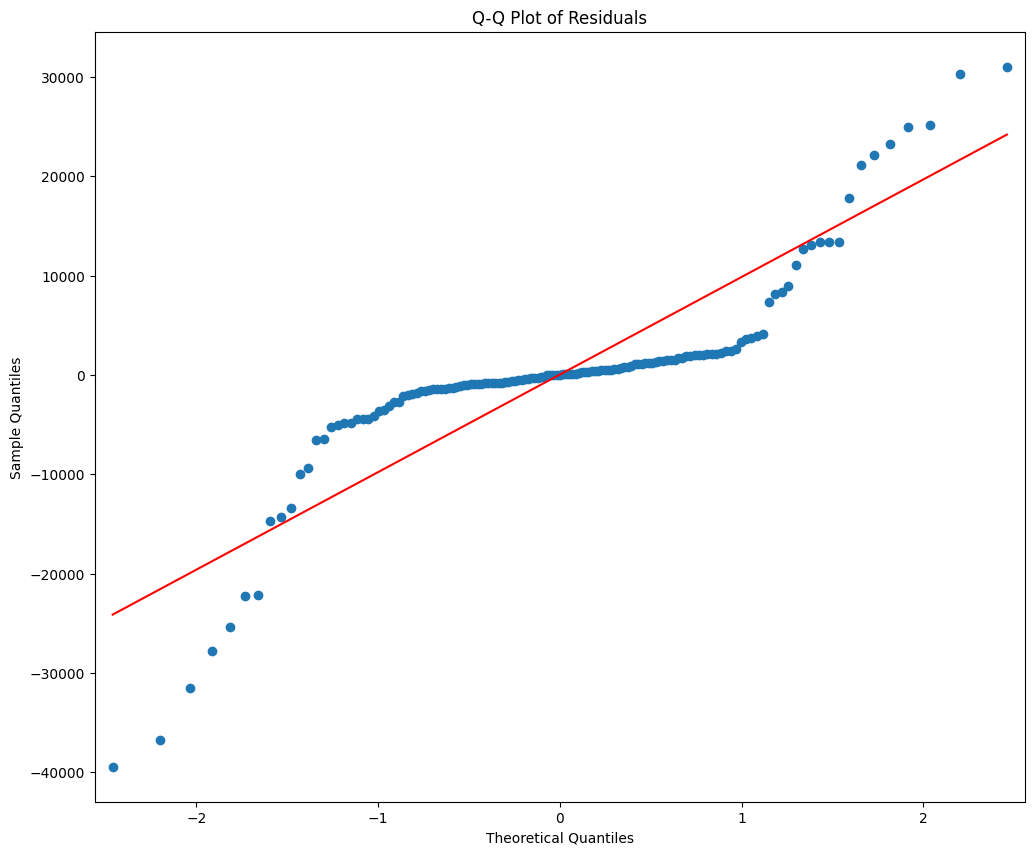

Ljung-Box test result:
     lb_stat  lb_pvalue
10  43.69763   0.000004


In [25]:
# Fit the best SARIMA model
model = SARIMAX(
    df_subset['Weekly_Sales'],
    order=(0, 1, 0),
    seasonal_order=(2, 1, 0, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
fitted_model = model.fit()

# Get residuals
residuals = fitted_model.resid

# Q-Q plot
sm.qqplot(residuals.dropna(), line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box test result:")
print(ljung_box_result)

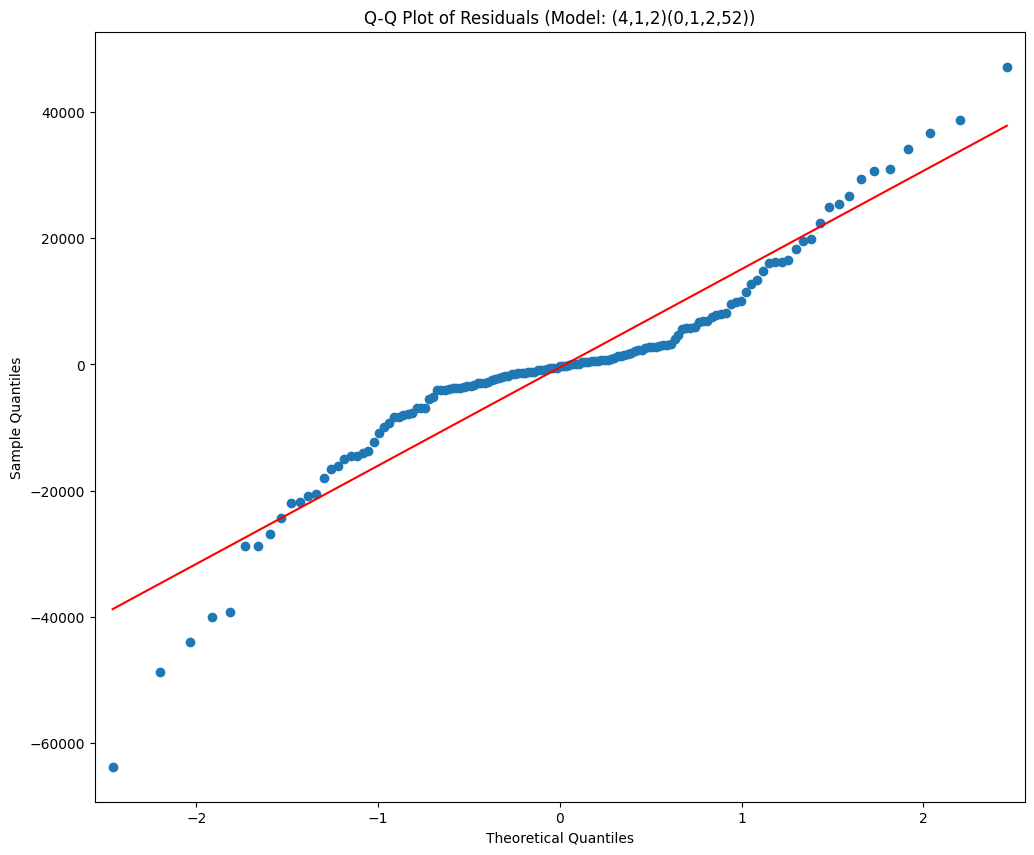

Ljung-Box test result:
      lb_stat  lb_pvalue
10  19.633173    0.03292


In [26]:
# Fit the new model based on ACF/PACF suggestion
model = SARIMAX(
    df_subset['Weekly_Sales'],
    order=(4, 1, 2),
    seasonal_order=(0, 1, 2, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
fitted_model = model.fit()

# Extract residuals
residuals = fitted_model.resid

# Q-Q Plot
sm.qqplot(residuals.dropna(), line='s')
plt.title("Q-Q Plot of Residuals (Model: (4,1,2)(0,1,2,52))")
plt.show()

# Ljung-Box Test
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box test result:")
print(ljung_box_result)


In [27]:
q1 = df_subset['Weekly_Sales'].quantile(0.25)
q3 = df_subset['Weekly_Sales'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

df_subset = df_subset[df_subset['Weekly_Sales'] < upper_bound]

In [28]:
df_subset['Log_Weekly_Sales'] = np.log1p(df_subset['Weekly_Sales'])

In [29]:
train_size = int(len(df_subset) * 0.8)
train_data = df_subset.iloc[:train_size]
test_data = df_subset.iloc[train_size:]
train_series = train_data['Log_Weekly_Sales']

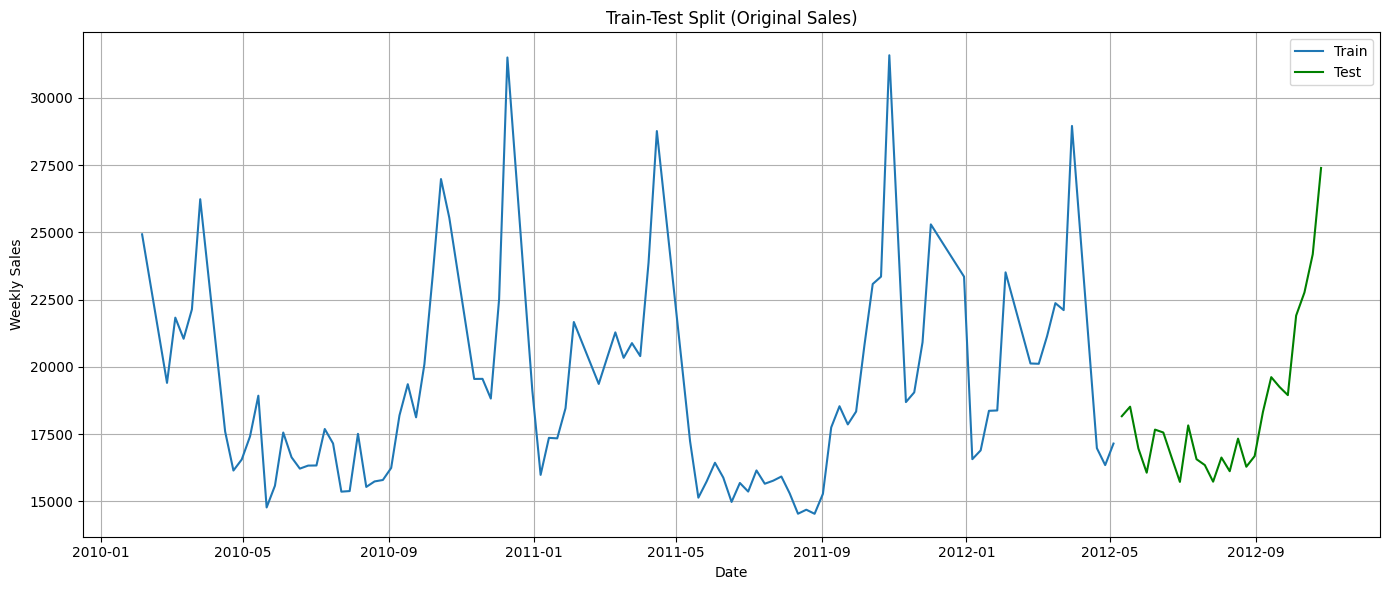

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], train_data['Weekly_Sales'], label='Train')
plt.plot(test_data['Date'], test_data['Weekly_Sales'], label='Test', color='green')
plt.title('Train-Test Split (Original Sales)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **SARIMA model**

In [31]:
model = SARIMAX(
    train_data['Log_Weekly_Sales'],
    order=(4, 1, 2),
    seasonal_order=(0, 1, 2, 52),
    enforce_stationarity=True,
    enforce_invertibility=True
)
fitted_model = model.fit(disp=False)

In [32]:
forecast_log = fitted_model.forecast(steps=len(test_data))
forecast_original = np.expm1(forecast_log)  # Inverse transform

In [33]:
from sklearn.metrics import mean_squared_error
mask = np.isfinite(forecast_original) & np.isfinite(test_data['Weekly_Sales'])
filtered_forecast = forecast_original[mask]
filtered_actual = test_data['Weekly_Sales'][mask]
mse = mean_squared_error(filtered_actual, filtered_forecast)
print(f"MSE after filtering: {mse:.2f}")


MSE after filtering: 7788000.20


In [34]:
# Reset index to ensure alignment
test_cleaned = test_data.reset_index(drop=True)

# Trim test_cleaned to match forecast size
trimmed_test = test_cleaned.iloc[:len(forecast_original)].copy()

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Date': trimmed_test['Date'].values,
    'Actual': trimmed_test['Weekly_Sales'].values,
    'Prediction': forecast_original.values
})

# Add error column
comparison_df['Error'] = comparison_df['Actual'] - comparison_df['Prediction']

# Display first few rows
comparison_df.head(10)


,Date,Actual,Prediction,Error
0,2012-05-11,18164.20,20296.388982,-2132.188982
1,2012-05-18,18517.79,26653.566887,-8135.776887
2,2012-05-25,16963.55,21908.831689,-4945.281689
3,2012-06-01,16065.49,17820.778118,-1755.288118
4,2012-06-08,17666.00,19042.991568,-1376.991568
5,2012-06-15,17558.82,23571.328312,-6012.508312
6,2012-06-22,16633.41,30411.711960,-13778.301960
7,2012-06-29,15722.82,21836.340396,-6113.520396
8,2012-07-06,17823.37,16287.974377,1535.395623
9,2012-07-13,16566.18,14234.946796,2331.233204


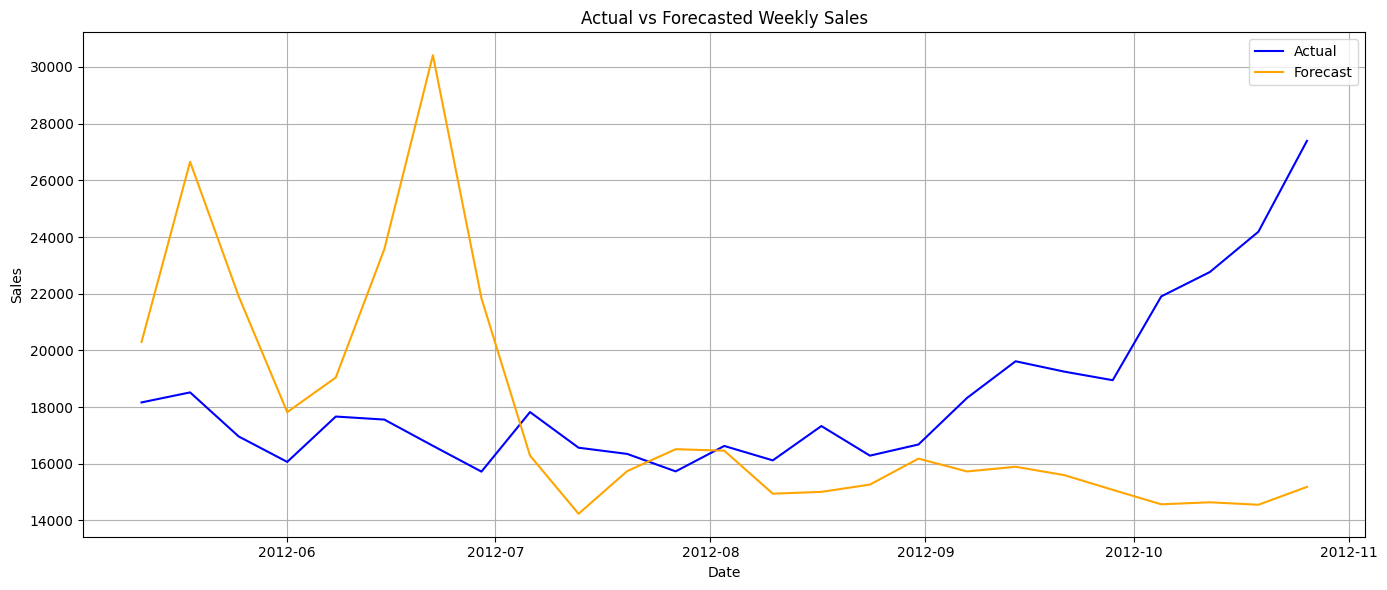

In [35]:
plt.figure(figsize=(14,6))
plt.plot(test_data['Date'], test_data['Weekly_Sales'], label='Actual', color='blue')
plt.plot(test_data['Date'], forecast_original, label='Forecast', color='orange')
plt.title('Actual vs Forecasted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##**SARIMAX model**

In [36]:
exog_cols = ['Fuel_Price', 'CPI', 'Unemployment']
exog_train = train_data[exog_cols]
exog_test = test_data[exog_cols]

model_sarimax = SARIMAX(
    train_data['Log_Weekly_Sales'],
    exog=exog_train,
    order=(4, 1, 2),
    seasonal_order=(0, 1, 2, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_sarimax = model_sarimax.fit(disp=False)
forecast_log = fitted_sarimax.forecast(steps=len(test_data), exog=exog_test)
forecast_original = np.expm1(forecast_log)


In [37]:
mask = np.isfinite(forecast_original) & np.isfinite(test_data['Weekly_Sales'])
filtered_forecast = forecast_original[mask]
filtered_actual = test_data['Weekly_Sales'][mask]
mse_sarimax = mean_squared_error(filtered_actual, filtered_forecast)
print(f"SARIMAX MSE (with exogenous): {mse_sarimax:.2f}")


SARIMAX MSE (with exogenous): 455937996.38


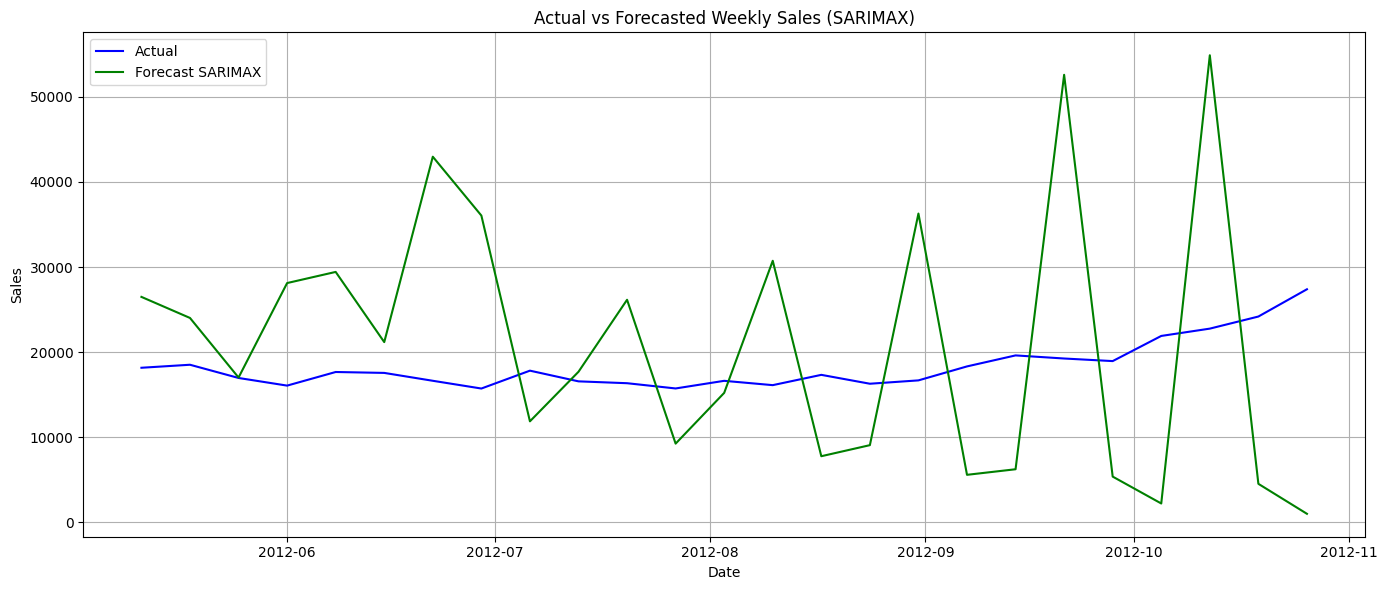

In [38]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'], test_data['Weekly_Sales'], label='Actual', color='blue')
plt.plot(test_data['Date'], forecast_original, label='Forecast SARIMAX', color='green')
plt.title('Actual vs Forecasted Weekly Sales (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **LSTM**

In [39]:
# Log transform
df_lstm = df_subset.copy()
df_lstm['Log_Weekly_Sales'] = np.log1p(df_lstm['Weekly_Sales'])

In [40]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
df_lstm['Scaled_Sales'] = scaler.fit_transform(df_lstm[['Log_Weekly_Sales']])


In [41]:
# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [42]:
# Use a window of 12 (yearly pattern)
window_size = 12
sales_series = df_lstm['Scaled_Sales'].values
X, y = create_sequences(sales_series, window_size)

In [43]:
# Train/Test Split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [44]:
# Reshape for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))  # Output layer

In [46]:
model.compile(optimizer='adam', loss='mse')

In [47]:
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1357 - val_loss: 0.0536
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0421 - val_loss: 0.0319
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0585 - val_loss: 0.0334
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0498 - val_loss: 0.0291
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0427 - val_loss: 0.0296
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0469 - val_loss: 0.0294
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0439 - val_loss: 0.0271
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0468 - val_loss: 0.0260
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0414 - val_loss: 0.0253
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0412 - val_loss: 0.0248
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0369 - val_loss: 0.0246
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0416 - val_lo

In [48]:
# Predict on test data
y_pred_scaled = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [49]:
# Inverse MinMax scaling
y_pred_log = scaler.inverse_transform(y_pred_scaled)

# Inverse log1p
y_pred = np.expm1(y_pred_log)

In [50]:
# first inverse scaling, then reverse log transformation for y_test
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_orig = np.expm1(y_test_log)

In [51]:
mse_lstm = mean_squared_error(y_test_orig, y_pred)
print(f"LSTM MSE: {mse_lstm:.2f}")

LSTM MSE: 3550249.58


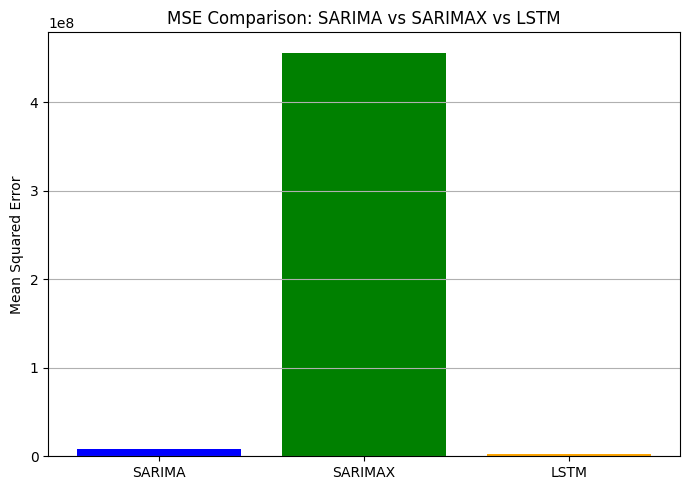

In [52]:
# Final MSE values
mse_sarima = 7788000.20
mse_sarimax = 455937996.38
mse_lstm = 2129504.43

# Labels and data
mse_vals = [mse_sarima, mse_sarimax, mse_lstm]
labels = ['SARIMA', 'SARIMAX', 'LSTM']

# Plot
plt.figure(figsize=(7, 5))
plt.bar(labels, mse_vals, color=['blue', 'green', 'orange'])
plt.title('MSE Comparison: SARIMA vs SARIMAX vs LSTM')
plt.ylabel('Mean Squared Error')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


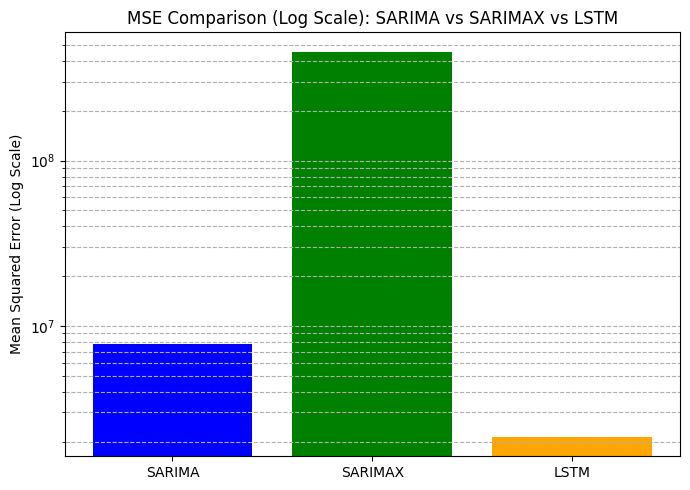

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Real MSE values
mse_sarima = 7788000.20
mse_sarimax = 455937996.38
mse_lstm = 2129504.43

# Labels and log values
mse_vals = [mse_sarima, mse_sarimax, mse_lstm]
labels = ['SARIMA', 'SARIMAX', 'LSTM']

plt.figure(figsize=(7, 5))
plt.bar(labels, mse_vals, color=['blue', 'green', 'orange'])
plt.yscale('log')  # log scale here
plt.title('MSE Comparison (Log Scale): SARIMA vs SARIMAX vs LSTM')
plt.ylabel('Mean Squared Error (Log Scale)')
plt.grid(True, which='both', axis='y', linestyle='--')
plt.tight_layout()
plt.show()


## **Clustring**

In [54]:
# Filter for one store and top 5 departments with enough data
df_store = df[df['Store'] == 1].copy()
top_depts = df_store['Dept'].value_counts().head(5).index

In [55]:
# Pivot to shape: each row = one time series (weekly sales per dept)
ts_data = []

for dept in top_depts:
    series = df_store[df_store['Dept'] == dept].sort_values('Date')['Weekly_Sales'].values
    ts_data.append(series)

In [56]:
# Convert to time series dataset
ts_data = to_time_series_dataset(ts_data)
print("Shape of time series dataset:", ts_data.shape)

Shape of time series dataset: (5, 143, 1)


In [57]:
# Choose number of clusters (e.g., 2 or 3)
n_clusters = 2

# Build the model using DTW
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
clusters = model.fit_predict(ts_data)

# Print cluster assignments
for i, dept in enumerate(top_depts):
    print(f"Dept {dept} → Cluster {clusters[i]}")


Dept 1 → Cluster 0
Dept 2 → Cluster 1
Dept 3 → Cluster 0
Dept 4 → Cluster 1
Dept 5 → Cluster 0


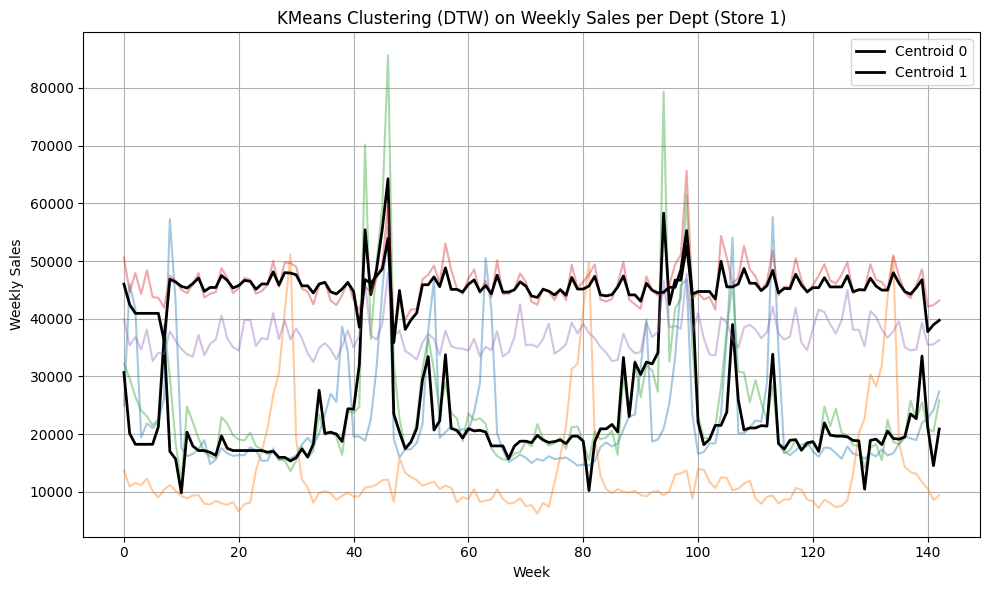

In [58]:
plt.figure(figsize=(10, 6))
for cluster_id in range(n_clusters):
    for ts in ts_data[clusters == cluster_id]:
        plt.plot(ts.ravel(), alpha=0.4)
    plt.plot(model.cluster_centers_[cluster_id].ravel(), color='black', linewidth=2, label=f'Centroid {cluster_id}')
plt.title("KMeans Clustering (DTW) on Weekly Sales per Dept (Store 1)")
plt.xlabel("Week")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
from tslearn.metrics import cdist_dtw

# Compute pairwise DTW distances
distance_matrix = cdist_dtw(ts_data)
sil_score = silhouette_score(distance_matrix, clusters, metric='precomputed')
print(f"Silhouette Score (DTW): {sil_score:.3f}")


Silhouette Score (DTW): 0.590
